**Data Cleaning**

In [1]:
!pip install statsmodels
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import seaborn as sns

In [2]:
df=pd.read_excel("north_india_agg_27march.xlsx")

In [3]:
df.isnull().sum()

,0
Date,4
Rohu_Small_MarketF,413
Catla_Small_MarketF,407
Grass_Carp_Small_MarketF,411
Common_Carp_Small_MarketF,408
...,...
Pangas_Catfish_Large_MarketU,366
Roopchand_Medium_MarketU,367
Roopchand_Large_MarketU,367
Common_Carp_Small_MarketU,366


In [4]:
df.shape

(436, 160)

In [5]:
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y',errors='coerce')
full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')})
df = full_dates.merge(df, on='Date', how='left')
df.set_index('Date',inplace=True)


In [6]:
df.isnull().sum()

,0
Rohu_Small_MarketF,409
Catla_Small_MarketF,403
Grass_Carp_Small_MarketF,407
Common_Carp_Small_MarketF,404
Roopchand_Small_MarketF,406
...,...
Pangas_Catfish_Large_MarketU,362
Roopchand_Medium_MarketU,363
Roopchand_Large_MarketU,363
Common_Carp_Small_MarketU,362


In [7]:
df.shape

(432, 159)

In [8]:
df.replace(0, np.nan, inplace=True)
df = df.interpolate(method="polynomial",order=2,limit_direction="both")
df = df.interpolate(method="linear",limit_direction="both")
for col in df.columns:
  df[col]=df[col].fillna(df[col].median())
for col in df.columns:
    if (df[col] < 0).any():
        smooth_mean = df.loc[df[col] > 0, col].mean()
        df[col] = df[col].apply(lambda x: x if x > 0 else smooth_mean)

In [9]:
null_columns = df.isna().any()

print(null_columns[null_columns == True].index)

Index([], dtype='object')


In [10]:
df.shape

(432, 159)

In [11]:
column_names=df.columns

In [12]:
for i in column_names:
  df[i+"_Cbrt"]=np.cbrt(df[i].clip(lower=0))

<ipython-input-12-63d55a37d831>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i+"_Cbrt"]=np.cbrt(df[i].clip(lower=0))
<ipython-input-12-63d55a37d831>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i+"_Cbrt"]=np.cbrt(df[i].clip(lower=0))
<ipython-input-12-63d55a37d831>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use 

**Determining stationarity of Data**

In [13]:
def stationary_test(dataframe,column):
  temp_df=dataframe.copy()
  temp_df.dropna(inplace=True)
  print("For the column {}".format(column))
  adftest=adfuller(temp_df[column],autolag='AIC')
  stats=pd.Series(adftest[1],index=['p-value'])
  print(stats)


In [14]:
df_dummy=df.copy()
for col in df_dummy.columns:
  stationary_test(df_dummy,col)

For the column Rohu_Small_MarketF
p-value    0.196412
dtype: float64
For the column Catla_Small_MarketF
p-value    0.000339
dtype: float64
For the column Grass_Carp_Small_MarketF
p-value    0.06192
dtype: float64
For the column Common_Carp_Small_MarketF
p-value    0.112093
dtype: float64
For the column Roopchand_Small_MarketF
p-value    0.034209
dtype: float64
For the column Pangas_Catfish_Small_MarketF
p-value    0.129961
dtype: float64
For the column Pangas_Catfish_Large_MarketC
p-value    0.000023
dtype: float64
For the column Pangas_Catfish_Medium_MarketC
p-value    0.000023
dtype: float64
For the column Pangas_Catfish_Small_MarketC
p-value    0.002684
dtype: float64
For the column Catla_Large_MarketC
p-value    0.000002
dtype: float64
For the column Catla_Medium_MarketC
p-value    0.000015
dtype: float64
For the column Catla_Small_MarketC
p-value    0.000015
dtype: float64
For the column Rohu_Large_MarketC
p-value    7.276518e-07
dtype: float64
For the column Rohu_Medium_MarketC
p

In [15]:
df.shape

(432, 318)

In [16]:
import matplotlib.pyplot as plt

def plot_series(historical_data, forecast_data):
    columns = column_names
    plt.figure(figsize=(16, 100))

    for i, col in enumerate(columns, 1):
        plt.subplot(42,4 , i)
        plt.plot(historical_data.index, historical_data[col], label='Historical', color='blue')
        plt.plot(forecast_data.index, forecast_data[col], label='Forecast', linestyle='--', color='red')
        plt.title(col.replace('_', ' '))
        plt.xticks(rotation=45)
        plt.ylim(0,2000)
        plt.legend()


    plt.tight_layout()
    plt.show()


In [17]:

df.columns

Index(['Rohu_Small_MarketF', 'Catla_Small_MarketF', 'Grass_Carp_Small_MarketF',
       'Common_Carp_Small_MarketF', 'Roopchand_Small_MarketF',
       'Pangas_Catfish_Small_MarketF', 'Pangas_Catfish_Large_MarketC',
       'Pangas_Catfish_Medium_MarketC', 'Pangas_Catfish_Small_MarketC',
       'Catla_Large_MarketC',
       ...
       'Pangas_Catfish_Small_MarketS_Cbrt', 'Rohu_Small_MarketU_Cbrt',
       'Catla_Small_MarketU_Cbrt', 'Pangas_Catfish_Small_MarketU_Cbrt',
       'Pangas_Catfish_Medium_MarketU_Cbrt',
       'Pangas_Catfish_Large_MarketU_Cbrt', 'Roopchand_Medium_MarketU_Cbrt',
       'Roopchand_Large_MarketU_Cbrt', 'Common_Carp_Small_MarketU_Cbrt',
       'Grass_Carp_Small_MarketU_Cbrt'],
      dtype='object', length=318)

In [18]:
0.75*df.shape[0]

324.0

**Dividing Data into Training and Testing**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 54.56
MSE: 193655.14
RMSE: 440.06
MAPE: 30.01%
sMAPE: 13.30%


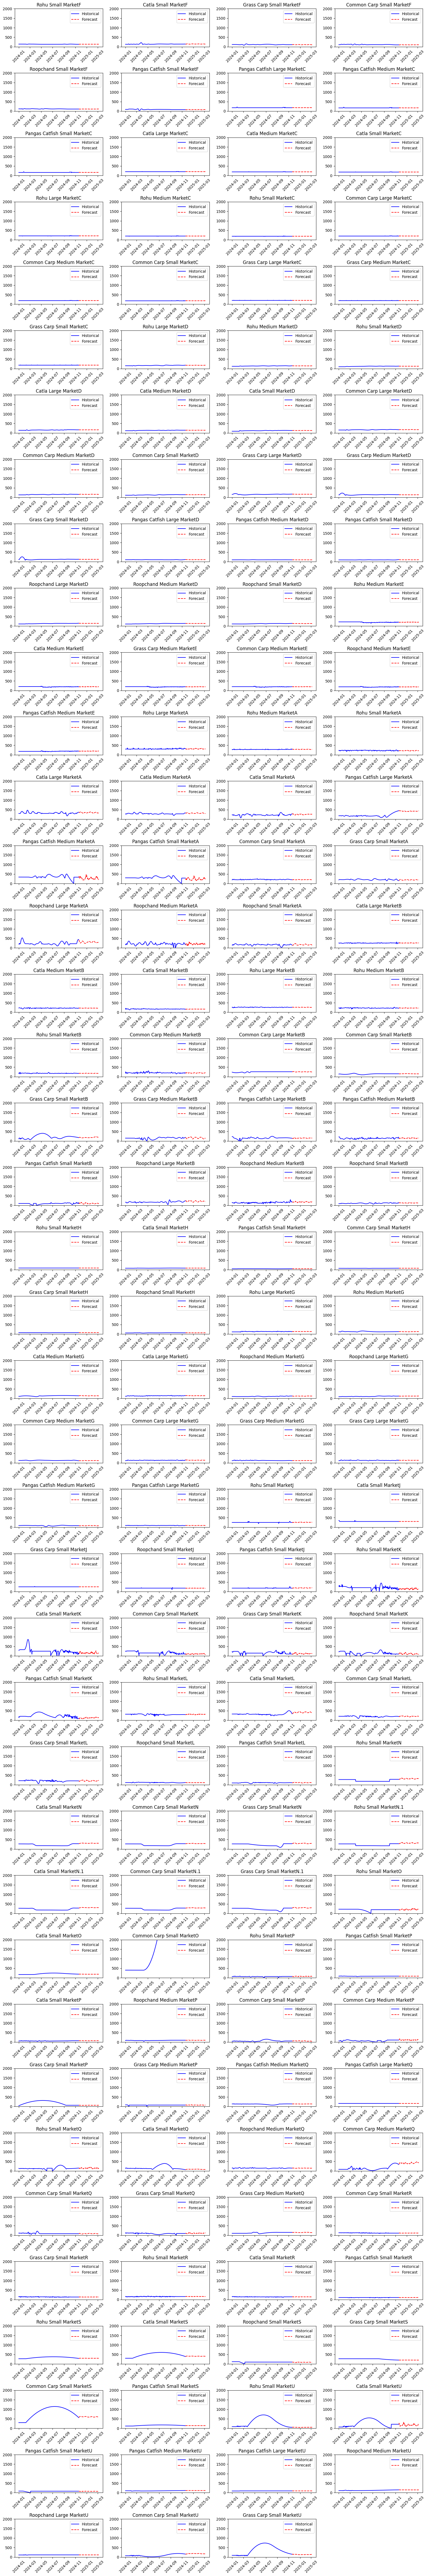

In [19]:
train=df[column_names].iloc[0:324]
test=df[column_names].iloc[324:]
train=np.cbrt(train)
test=np.cbrt(test)

scaler = RobustScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
lag_order=30
model = VAR(train_scaled)
results=model.fit(maxlags=lag_order,method='ols')
forecast_scaled = results.forecast(train_scaled.values[-lag_order:], steps=len(test))
forecast = scaler.inverse_transform(forecast_scaled)
forecast_data = pd.DataFrame(forecast, index=test.index, columns=train.columns)
train=np.power(train,3)
test=np.power(test,3)
forecast_data=np.power(forecast_data,3)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(test, forecast_data)
mse = mean_squared_error(test, forecast_data)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_data) / test)) * 100
smape = np.mean(2 * np.abs(test - forecast_data) / (np.abs(test) + np.abs(forecast_data))) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
plot_series(train,forecast_data)

**Using the Entire Data for Training and Testing**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 42.76
MSE: 85756.45
RMSE: 292.84
MAPE: 25.78%
sMAPE: 15.15%


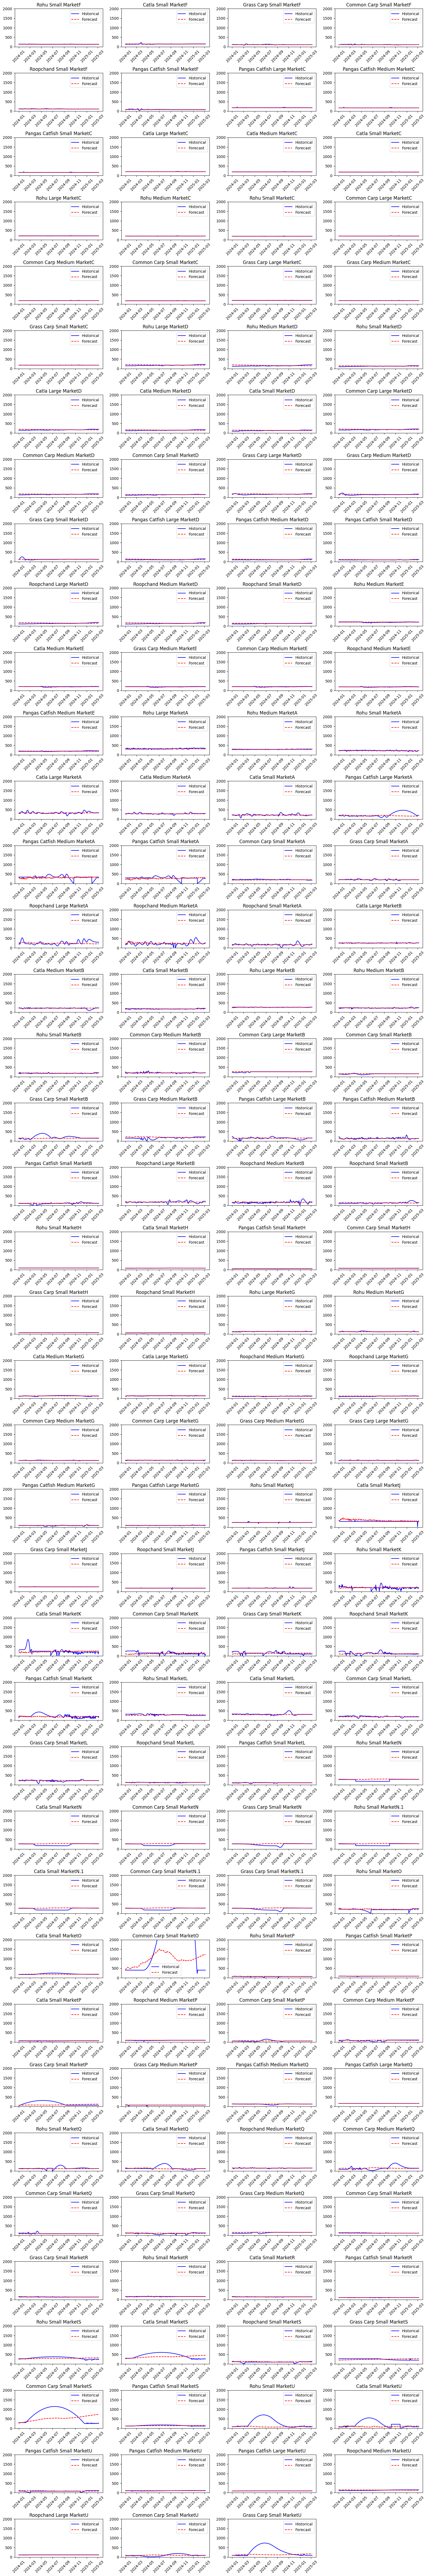

In [20]:
train=df[column_names]
test=df[column_names]
train=np.cbrt(train)
test=np.cbrt(test)

scaler = RobustScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
lag_order=30
model = VAR(train_scaled)
results=model.fit(maxlags=lag_order,method='ols')
forecast_scaled = results.forecast(train_scaled.values[-lag_order:], steps=len(test))
forecast = scaler.inverse_transform(forecast_scaled)
forecast_data = pd.DataFrame(forecast, index=test.index, columns=train.columns)
train=np.power(train,3)
test=np.power(test,3)
forecast_data=np.power(forecast_data,3)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(test, forecast_data)
mse = mean_squared_error(test, forecast_data)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast_data) / test)) * 100
smape = np.mean(2 * np.abs(test - forecast_data) / (np.abs(test) + np.abs(forecast_data))) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
plot_series(train,forecast_data)
with open('model.pkl','wb') as file:
  pickle.dump(results,file)

**Function to be used for Deployment**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pickle
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from datetime import datetime


In [22]:
def get_fish_column(fish, size, market):

    fish_mapping = {
        "Pangas Catfish": "Pangas_Catfish",
        "Catla": "Catla",
        "Rohu": "Rohu",
        "Common Carp": "Common_Carp",
        "Grass Carp": "Grass_Carp",
        "Roopchand": "Roopchand"
    }


    size_mapping = {
        "Small": "Small",
        "Medium": "Medium",
        "Large": "Large"
    }

    market_mapping = {
        "DDA Market": "A",
        "Ghazipur Market": "B",
        "Barnala Market": "C",
        "Ludhiana Market": "D",
        "Sunam Dhuri Market": "E",
        "Amritsar Market": "F",
        "Faridabad Market": "G",
        "Yamuna Nagar Market": "H",
        # "Donar Wholesale Market":"I",
        "Macchwatoli Retail Fish Market":"J",
        "Mushallapur Wholesale Fish Market":"K",
        "Saidnagar Retail Fish Market":"L",
        "Bhakra Gobind Sagar Fish Landing Center":"M",
        "Nagrota Surian Fish Landing Center":"N",
        "Fish Retail Market Gumma Shimla":"O",
        "Jaipur Wholesale Fish Market":"P",
        "Udaipur Retail Fish Market":"Q",
        "Wholesale Market Dubagga Lucknow":"R",
        "Retail Market Mahesara Gorakhpur":"S",
        # "JK Fish Sahasthadhara Wholesale Market":"T",
        "Naveen Krishi Mandi Wholesale Fish Market":"U"
    }

    if fish in fish_mapping and size in size_mapping and market in market_mapping:
        return f"{fish_mapping[fish]}_{size_mapping[size]}_Market{market_mapping[market]}"
    else:
        return "Incorrect Input"

In [23]:
def predict(fore_date,market,fish,size):
  train_data=pd.read_excel("north_india_agg_27march.xlsx")
  train_data.dropna(subset=['Date'], inplace=True)
  train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d-%m-%Y',errors='coerce')
  full_dates = pd.DataFrame({'Date': pd.date_range(start=train_data['Date'].min(), end=train_data['Date'].max(), freq='D')})
  train_data = full_dates.merge(train_data, on='Date', how='left')
  train_data.set_index('Date',inplace=True)
  train_data.replace(0, np.nan, inplace=True)
  train_data = train_data.interpolate(method="polynomial",order=2,limit_direction="both")
  train_data = train_data.interpolate(method="linear",limit_direction="both")
  for col in train_data.columns:
    train_data[col]=train_data[col].fillna(train_data[col].median())
  for col in train_data.columns:
    if (train_data[col] < 0).any():
      smooth_mean = train_data.loc[train_data[col] > 0, col].mean()
      train_data[col] = train_data[col].apply(lambda x: x if x > 0 else smooth_mean)
  scaler=RobustScaler()
  train_scaled = pd.DataFrame(scaler.fit_transform(np.cbrt(train_data)),
                                columns=train_data.columns,
                                index=train_data.index)
  baseline_date=datetime.strptime("07-03-2025", "%d-%m-%Y")
  with open('model.pkl','rb') as file:
    model=pickle.load(file)
  if(fore_date<baseline_date):
    return "enter dates after 7th March,2025 only"
  steps=(fore_date-baseline_date).days
  lag_order = model.k_ar
  forecast_scaled = model.forecast(train_scaled.values[-lag_order:], steps=steps)
  forecast = scaler.inverse_transform(forecast_scaled)
  forecast_data = pd.DataFrame(forecast, columns=train_data.columns)
  forecast_data = np.power(forecast_data, 3)
  fish_and_size=""
  fish_and_size=get_fish_column(fish,size,market)
  if fish_and_size not in forecast_data.columns:
    return "Incorrect Input"
  fish_data=forecast_data[fish_and_size]
  forecast_dates=[]
  final_forecast_data={
      'Date':[],
      'Prediction':[]
  }
  forecast_single = forecast_scaled[-1].reshape(1, -1)
  forecast = scaler.inverse_transform(forecast_single)
  forecast_data = pd.DataFrame(forecast, columns=train_data.columns)
  forecast_data = np.power(forecast_data, 3)
  if fish_and_size not in forecast_data.columns:
    return "Incorrect Input"
  predicted_price = np.round(forecast_data.loc[0, fish_and_size])
  print( f"Predicted price of {fish} ({size}) on {fore_date.strftime('%d-%m-%Y')}: {predicted_price} Rupees in {market}")


In [24]:
predict(datetime.strptime("07-04-2025", "%d-%m-%Y"),"Udaipur Retail Fish Market","Pangas Catfish","Medium")

Predicted price of Pangas Catfish (Medium) on 07-04-2025: 128.0 Rupees in Udaipur Retail Fish Market


In [25]:
predict(datetime.strptime("20-04-2025", "%d-%m-%Y"),"Amritsar Market","Rohu","Small")

Predicted price of Rohu (Small) on 20-04-2025: 129.0 Rupees in Amritsar Market


In [26]:
predict(datetime.strptime("15-08-2025", "%d-%m-%Y"),"Barnala Market","Grass Carp","Medium")

Predicted price of Grass Carp (Medium) on 15-08-2025: 192.0 Rupees in Barnala Market


In [27]:
predict(datetime.strptime("30-06-2025", "%d-%m-%Y"),"Ludhiana Market","Catla","Large")

Predicted price of Catla (Large) on 30-06-2025: 181.0 Rupees in Ludhiana Market
